<h2> HW 3 </h2>
<h3> Problem 1</h3>

In [1]:
from sklearn.datasets import make_blobs
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
import numpy as np
import pandas as pd
from functools import reduce
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.matlib import repmat
sns.set_theme(style="darkgrid")
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
offset = 2

In [3]:
def toydata(size,d,state):
        X, y = make_blobs(n_samples=[size,size], centers=[[0,0],[offset,offset]], n_features=d,random_state=state)
        y+=1
        return X,y

In [4]:
X, y = toydata(1000,2,0)

<AxesSubplot:>

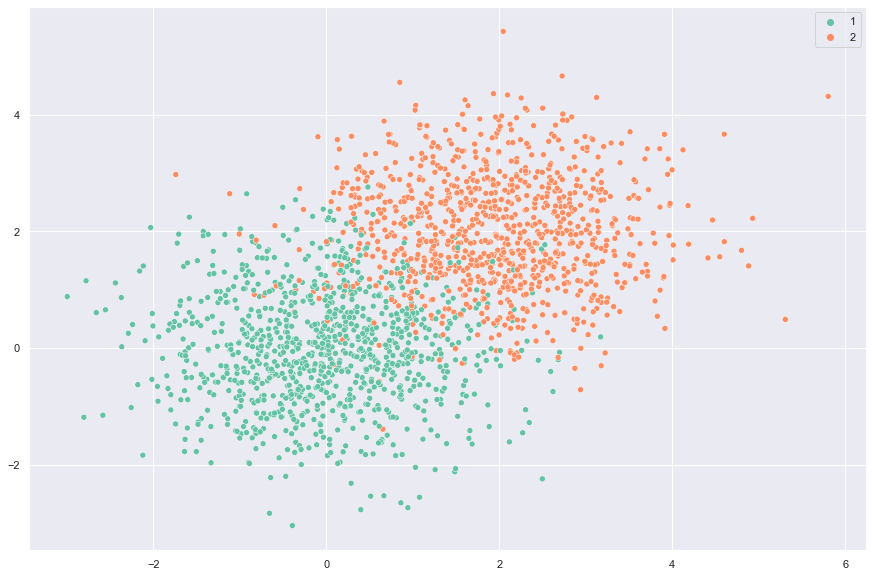

In [5]:
plt.figure(figsize=(15,10))
sns.scatterplot(x=X[:,0],y=X[:,1],hue=y,palette="Set2")

In [6]:
from scipy.stats import multivariate_normal

def pdfval(x,mu,sigma):
    return multivariate_normal.pdf(x,mean=np.array([mu,mu]),cov=np.array([[sigma,0],[0,sigma]]))

Function computeybar - A function to compute the posterior of test data using naive bayes. Latest this is used to compute the noise.

With the equations, $p(\vec x|y=1)\sim {\mathcal{N}}(0,{I}) \textrm { and } p(\vec x|y=2)\sim {\mathcal{N}}(\mu_2,{I})$, we can compute the probability $p(\vec x|y)$. Then used Bayes rule to compute $p(y|\vec x)$. Then computed $\bar{y}=E(y)=1*p(y=1|\vec x) + 2*p(y=2|\vec x)$

In [7]:
def computeybar(x,y,mu1,sigma1,mu2,sigma2):
    pxy1=pdfval(x,mu1,sigma1)
    pxy2=pdfval(x,mu2,sigma2)
    py1=len(y[y==1])/len(y)
    py2=len(y[y==2])/len(y)
    py1x=pxy1*py1/(pxy1*py1+pxy2*py2)
    py2x=pxy2*py2/(pxy1*py1+pxy2*py2)
    ybar=(1.*py1x+2.*py2x)
    return ybar
    

(2000,)
Number of points misclassified : 140


<AxesSubplot:>

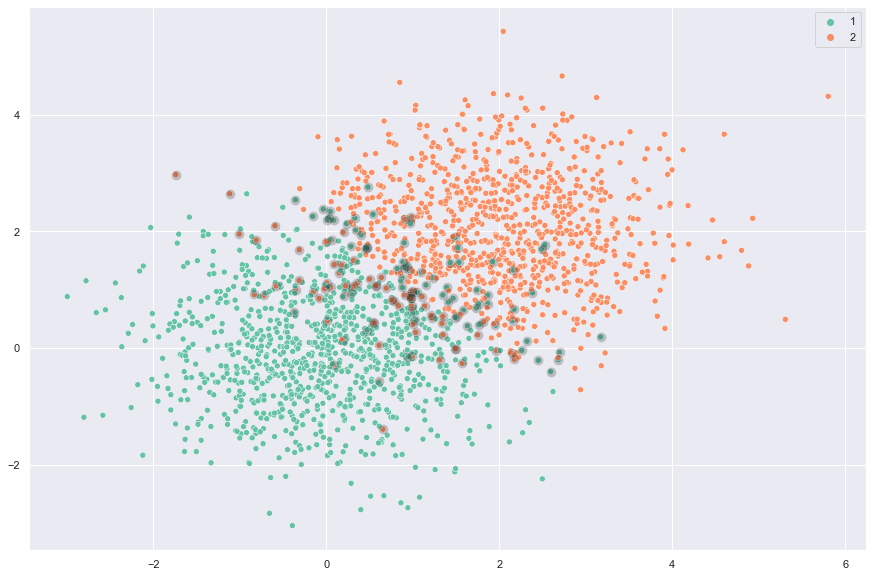

In [8]:
#to demonstrate how computeybar can be used to show the misclassified points.

ybar=computeybar(X,y,0,1,offset,1)
print(ybar.shape)
predictions = np.round(ybar)
errors=predictions!=y
Xerrors = X[errors]
print("Number of points misclassified : {}".format(len(Xerrors)))
plt.figure(figsize=(15,10))
sns.scatterplot(x=X[:,0],y=X[:,1],hue=y,palette="Set2")
sns.scatterplot(x=X[errors,0],y=X[errors,1],color="black",s=100,alpha=0.2)

function computehbar - to get the average prediction of test set of points on which is approximated by computing outcomes on various models trained on different datasets and taking average of them.



In [9]:


def computehbar(xtest,nmodels=100,trainsize=100,alpha=1,d=2):
    
    hbar=np.zeros(xtest.shape[0])
    for i in range(nmodels):
        X,y = toydata(size=trainsize,d=d,state=np.random.randint(nmodels))
        clf=KernelRidge(kernel="rbf",alpha=alpha)
        clf.fit(X, y) 
        hbar+=clf.predict(xtest)
        
    return (hbar/nmodels)

function computevariance - to calculate variance on how wide the spread of the predictions of the test data compared to the mean hbar

In [10]:
def computevariance(xtest,hbar,nmodels=100,alpha=1,trainsize=100,d=2):
        
        variance = np.zeros(xtest.shape[0])    
        for j in range(nmodels):
            X, y = toydata(size=trainsize,d=2,state=np.random.randint(nmodels))
            clf=KernelRidge(kernel="rbf",alpha=alpha)
            clf.fit(X, y)
            pred=clf.predict(xtest)
            diffSqr = (pred - hbar)**2
            variance += diffSqr
    
        variance = np.mean(variance)/nmodels
        return variance

Below cell will combine everything above to understand how the bias, noise and variance trade off works and compute the total error for the below equation. 
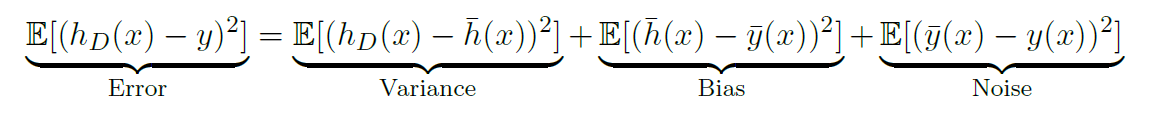

In [11]:
#Full Execution

#Intitalize the sizes and range of lambdas 
smallsize = 10
bigsize = 5000
nmodels = 100
alphas = np.arange(-8, 0.5, 0.5)

#to store all the execution outputs
nalphas = len(alphas)
mbias = np.zeros(nalphas)
mvariance = np.zeros(nalphas)
mtotal = np.zeros(nalphas)
mnoise = np.zeros(nalphas)
msum = np.zeros(nalphas)

# Execute for different regularization parameters
for i in range(nalphas):
    alpha = 2 ** alphas[i]
    # use this data set as an approximation of the true test set
    xtest, ytest = toydata(size=bigsize,d=2,state=np.random.randint(nmodels))
    # Estimate the Total Model Error P()
    total = 0
    for j in range(nmodels):
        X, y = toydata(size=smallsize,d=2,state=np.random.randint(nmodels))
        clf=KernelRidge(kernel="rbf",alpha=alpha)
        clf.fit(X, y)
        pred=clf.predict(xtest)        
        total += np.mean((pred - ytest) ** 2)
    total /= nmodels
    
    # Estimate Noise
    ybar = computeybar(xtest,ytest,0,1,offset,1)
    noise = np.mean((ytest-ybar) ** 2)
    
    # Estimate Bias
    hbar=computehbar(xtest,nmodels=nmodels,trainsize=smallsize,alpha=alpha,d=2)
    bias = np.mean((hbar-ybar) ** 2)
    
    # Estimating VARIANCE
    variance = computevariance(xtest,hbar,nmodels=nmodels,alpha=alpha,trainsize=smallsize,d=2)
    
    
    # print and store results
    mbias[i] = bias
    mvariance[i] = variance
    mtotal[i] = total
    mnoise[i] = noise
    msum[i] = bias+variance+noise
    print('Regularization λ=2^%2.1f: Bias: %2.4f Variance: %2.4f Noise: %2.4f Bias+Variance+Noise: %2.4f Test error: %2.4f'
          % (alphas[i],mbias[i],mvariance[i],mnoise[i],msum[i],mtotal[i]))


Regularization λ=2^-8.0: Bias: 0.0943 Variance: 0.2587 Noise: 0.0576 Bias+Variance+Noise: 0.4106 Test error: 0.3848
Regularization λ=2^-7.5: Bias: 0.1015 Variance: 0.2147 Noise: 0.0562 Bias+Variance+Noise: 0.3724 Test error: 0.3586
Regularization λ=2^-7.0: Bias: 0.0951 Variance: 0.1959 Noise: 0.0588 Bias+Variance+Noise: 0.3499 Test error: 0.3520
Regularization λ=2^-6.5: Bias: 0.0890 Variance: 0.1758 Noise: 0.0572 Bias+Variance+Noise: 0.3220 Test error: 0.2997
Regularization λ=2^-6.0: Bias: 0.0906 Variance: 0.1509 Noise: 0.0563 Bias+Variance+Noise: 0.2979 Test error: 0.2723
Regularization λ=2^-5.5: Bias: 0.0916 Variance: 0.1320 Noise: 0.0583 Bias+Variance+Noise: 0.2819 Test error: 0.2857
Regularization λ=2^-5.0: Bias: 0.0931 Variance: 0.1243 Noise: 0.0563 Bias+Variance+Noise: 0.2737 Test error: 0.2704
Regularization λ=2^-4.5: Bias: 0.0977 Variance: 0.0970 Noise: 0.0591 Bias+Variance+Noise: 0.2538 Test error: 0.2590
Regularization λ=2^-4.0: Bias: 0.1135 Variance: 0.1078 Noise: 0.0565 Bia

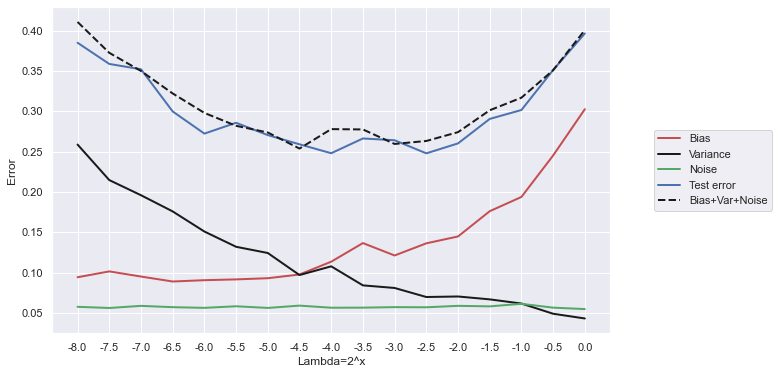

In [12]:
# plot results
plt.figure(figsize=(10,6))
plt.plot(mbias[:nalphas],c='r',linestyle='-',linewidth=2)
plt.plot(mvariance[:nalphas],c='k', linestyle='-',linewidth=2)
plt.plot(mnoise[:nalphas],c='g', linestyle='-',linewidth=2)
plt.plot(mtotal[:nalphas],c='b', linestyle='-',linewidth=2)
plt.plot(msum[:nalphas],c='k', linestyle='--',linewidth=2)

plt.legend(["Bias","Variance","Noise","Test error","Bias+Var+Noise"],loc='center right',bbox_to_anchor=(1.3,0.5));
plt.xlabel("Lambda=2^x",fontsize=12);
plt.ylabel("Error",fontsize=12);
plt.xticks([i for i in range(nalphas)],alphas);


<h3> Problem 2 </h3>

$Q 2(a)$
<br>
SVM with RBF Kernel would be a good choice for this problem as the classes are not linearly separable.
If we just use clustering or KNN, lts might not be good as there are overlapping regions in the outputs and they are not linearly separable. So we need to go with kernel trick and SVM with RBF kernel would be good choice to explore.

In [13]:
data=pd.read_csv('hw3_data2.txt',header=None,names=["class","x1","x2"])

In [14]:
data.head()

,class,x1,x2
0,+,1.607874,9.247557
1,+,3.003258,6.610258
2,+,4.069008,18.327280
3,+,0.407198,14.835517
4,+,13.747305,8.219991


In [15]:
data["y"]=0

In [16]:
data.loc[data["class"]=="+","y"]=1

In [17]:
data.head()

,class,x1,x2,y
0,+,1.607874,9.247557,1
1,+,3.003258,6.610258,1
2,+,4.069008,18.327280,1
3,+,0.407198,14.835517,1
4,+,13.747305,8.219991,1


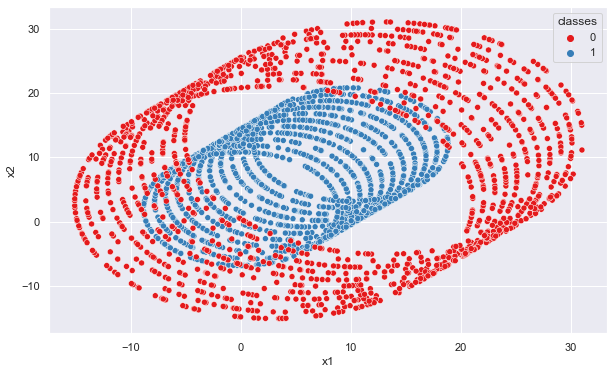

In [18]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=data["x1"],y=data["x2"],hue=data["y"], palette="Set1")
plt.legend(title="classes")

In [19]:
from sklearn import svm
from sklearn.model_selection import train_test_split

In [20]:
#build custom kernel

def build_RBF2(gamma):    
    def compute_RBF2(X_1, X_2):
        X1=np.array(X_1)
        X2=np.array(X_2)
        n=X1.shape[0]
        m=X2.shape[0]
        diff = X1[:, np.newaxis] - X2
        k = np.square(np.linalg.norm(diff, axis = 2))
        k*=-1.*gamma
        return np.exp(k)
    return compute_RBF2

In [21]:
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt


X=data[["x1","x2"]] 
y = data["y"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

def make_meshgrid(x, y, h=.6):
    x_min, x_max = x.min()-1, x.max() + 1
    y_min, y_max = y.min()-1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

# The classification SVC model
model = svm.SVC(kernel=build_RBF2(gamma=0.01))
clf = model.fit(X_train, y_train)

predictions = clf.predict(X_test)
errors=predictions!=y_test
accuracy = len(y_test[predictions==y_test])/len(y_test)
print("Accuracy : {0:.2f}%".format(accuracy*100))
X_errors=X_test[errors]
y_errors=y_test[errors]


print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

Accuracy : 94.17%
[[125  21]
 [  0 214]]
              precision    recall  f1-score   support

           0       1.00      0.86      0.92       146
           1       0.91      1.00      0.95       214

    accuracy                           0.94       360
   macro avg       0.96      0.93      0.94       360
weighted avg       0.95      0.94      0.94       360



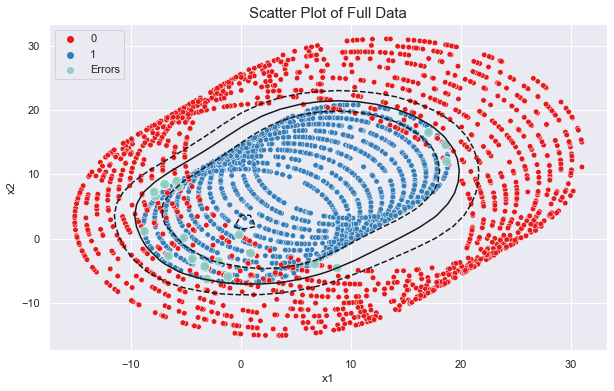

In [22]:
plt.figure(figsize=(10,6))

sns.scatterplot(x=X.iloc[:, 0],y= X.iloc[:, 1], hue=y, s=30, palette="Set1")
sns.scatterplot(x=X_errors.iloc[:,0],y= X_errors.iloc[:,1],hue=["Errors"]*X_errors.shape[0],s=100,alpha=0.9,palette="Set3")
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)
ax.contour(
    XX, YY, Z, colors="k", levels=[-1, 0, 1], alpha=1, linestyles=["--", "-", "--"]
)

plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Scatter Plot of Full Data",size=15)

plt.show()

<h3> Problem 3 </h3>

$3(a)$

Since the given problem is assumed to be joint gaussian distribution of $\mathbf{y},\mathbf{y_*}$, we can use the conditioning rules of gaussian distribution which states that, 
<br> $$\textrm{"Conditioning a Gaussian gives another Gaussian"}$$

The rule is, if
$$\begin{bmatrix} x \\ y \end{bmatrix} \sim \mathcal{N}\begin{pmatrix}0,\begin{bmatrix} A & C^T \\ C & B \end{bmatrix}\end{pmatrix}$$
then, $$ \textbf{Rule 1:} P(x|y) \sim \mathcal{N} \begin{pmatrix} C^{T}B^{-1}y, A-C^{T}B^{-1}C \end{pmatrix}$$
$$ \textbf{Rule 2:} P(y|x) \sim \mathcal{N} \begin{pmatrix} CA^{-1}y, B-CA^{-1}C^{T} \end{pmatrix}$$

Now, we are given that,

$$\begin{pmatrix} y \\ y^* \end{pmatrix} \sim \mathcal{N}\begin{pmatrix} \begin{bmatrix} 0_n \\ 0_m \end{bmatrix} \begin{bmatrix} k(X,X) & k(X,X^*) \\ k(X^*,X) & k(X^*,X^*)\end{bmatrix}\end{pmatrix}
$$

where $y^*$ are the test outcomes and $X^*$ as test observations.
Thus, with second rule above we can condition the joint probability distribution as 

$$
P(y^*|y) \sim \mathcal{N} (k(X^*,X)k(X,X)^{-1}y,k(X^*,X^*)-k(X^*,X)k(X,X)^{-1}k(X,X^*))
$$

The proof of Rule 1, Rule 2 can be seen here. 
https://fabiandablander.com/statistics/Two-Properties.html

In [23]:
# helper function for plotting
# inspired by https://github.com/krasserm/bayesian-machine-learning/blob/master/gaussian_processes_util.py

def plot_gps(mu, covmat, X, X_train=None, Y_train=None, samples=[]):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(covmat))
    
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.2)
    plt.plot(X, mu, label='Mean')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'ro')
    plt.legend(bbox_to_anchor=(1.04,0.5),loc='center left')

In [24]:
def rbf_kernel(X1, X2, h=1.0, sigma=1.0):
        return sigma * np.exp(-0.5 / h**2 * (np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)))
    

In [25]:
def GPRegression(xTrain, yTrain, xTest, h=1.0, sigma=1.0,gamma=1e-5):
    K11 = rbf_kernel(xTrain,xTrain,h,sigma) + gamma**2*np.eye(len(xTrain))
    K21 = rbf_kernel(xTrain,xTest, h, sigma)
    K22 = rbf_kernel(xTest,xTest, h ,sigma)+ gamma**2*np.eye(len(xTest))
    #ym=np.mean(yTrain)
    # mean 
    mu = K21.T.dot(np.linalg.inv(K11)).dot(yTrain)
    # covariance 
    covmat = K22 - K21.T.dot(np.linalg.inv(K11)).dot(K21)
    return mu, covmat

Optimised the above implementation using the Cholskey Decomposition and used below algorithm to return Predictive Mean and Variance. Log Likelihood is added later part of the notebook.

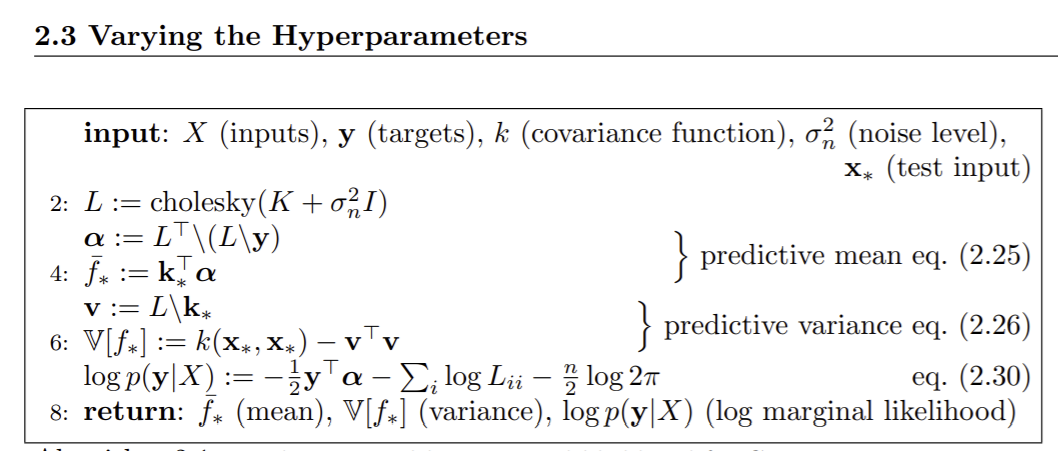

In [26]:
def GPRegressionOptimised(xTrain, yTrain, xTest, h=1.0, sigma=1.0,gamma=1e-5):
    #ym=np.mean(yTrain)
    K11 = rbf_kernel(xTrain,xTrain,h,sigma) + gamma**2*np.eye(len(xTrain))
    K21 = rbf_kernel(xTrain,xTest, h, sigma)
    K22 = rbf_kernel(xTest,xTest, h ,sigma)+ gamma**2*np.eye(len(xTest))
    L=np.linalg.cholesky(K11)
    
    #mean
    alpha = np.linalg.inv(L.T).dot(np.linalg.inv(L).dot(yTrain))
    mu=K21.T.dot(alpha)
    
    #variance
    v=np.linalg.inv(L).dot(K21)
    covmat=K22-(v.T).dot(v)
    
    
    return mu, covmat

Text(0.5, 1.0, 'Posterior Predictive Distribution of GP with RBF Kernel')

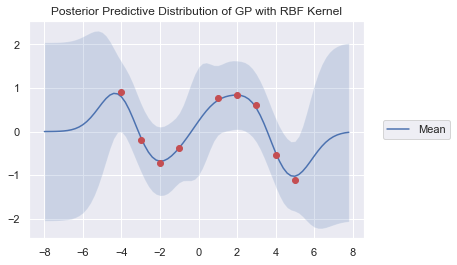

In [27]:
#To test the function on some sample created
noise = 0.3
X_train = np.expand_dims(np.array([-4, -3, -2, -1, 1,2,3, 4,5]),axis=1)
np.random.seed(42)
Y_train = np.sin(X_train) + noise* np.random.randn(X_train.shape[0],1)
X = np.arange(-8, 8, .2)
X = np.expand_dims(X,1)
# Compute mean and covariance of the posterior predictive distribution
mu, covmat = GPRegressionOptimised(X_train, Y_train,X,gamma=noise)
samples = [] #np.random.multivariate_normal(mu.ravel(), covmat, 3)
plot_gps(mu, covmat, X, X_train=X_train, Y_train=Y_train, samples=samples)
plt.title('Posterior Predictive Distribution of GP with RBF Kernel')

In [28]:
def LogMarinalLikelihood(X_train, Y_train, h=1.0, sigma=1.0,gamma=1e-5):        
    K = rbf_kernel(X_train, X_train, h, sigma) + gamma**2 * np.eye(len(X_train))
    L = np.linalg.cholesky(K)
    alpha = np.linalg.inv(L.T).dot(np.linalg.inv(L).dot(Y_train))
    return -1*(np.sum(np.log(np.diagonal(L))) + 0.5 * Y_train.T.dot(alpha) +  0.5 * len(X_train) * np.log(2*np.pi)).ravel()[0]

In [29]:
LogMarinalLikelihood(X_train, Y_train)

-8.306801544404975

In [30]:
from math import inf

def HyperParameters(X_train,Y_train,hs,sigmas):
    gamma=0.01*np.std(Y_train)
    best_val=-inf
    h,sigma = np.meshgrid(hs, sigmas)
    h_t=list(h.flat)
    sigma_t=list(sigma.flat)
    for i in range(len(h_t)):
        val=LogMarinalLikelihood(X_train,Y_train,h_t[i],sigma_t[i],gamma)
        #print("h: {},sigma: {}, val={}".format(h_t[i],sigma_t[i],val))
        if(val>best_val):
            best_val=val
            best_h=h_t[i]
            best_sigma=sigma_t[i]
    
    return best_val,best_h,best_sigma
        

In [31]:
#loadData
data=pd.read_excel('Concrete_Data.xls')

In [32]:
X=np.array(data.iloc[:,:-1])
y=np.array(data.iloc[:,-1:])

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [34]:
#Train the model with default parameters
mu,convmat=GPRegressionOptimised(X_train, y_train, X_test)

In [35]:
#Generate Hyper Parameter Space
hs=np.logspace(-1,1,10)*np.linalg.norm(np.std(X_train,axis=0))
sigmas=np.logspace(-1,1,10)*np.std(y_train)

In [36]:
hs

array([  19.94123702,   33.26398818,   55.48767656,   92.55902308,
        154.39775612,  257.55097993,  429.62092797,  716.65090074,
       1195.44575252, 1994.12370197])

In [37]:
sigmas

array([  1.67327626,   2.79119303,   4.65599059,   7.7666604 ,
        12.95557039,  21.61119393,  36.0496442 ,  60.13443086,
       100.31027642, 167.32762598])

In [38]:
#Train for the best hyper meters from the space available for maximum marginal likelihood
val,hbest,sbest=HyperParameters(X_train,y_train,hs,sigmas)

In [39]:
print(val,hbest,sbest)

-27382.953681410898 19.94123701968107 167.32762598041012


In [40]:
#Run the GPR with the parameters found
mubest,convmatbest=GPRegressionOptimised(X_train, y_train, X_test, h=hbest, sigma=sbest,gamma=0.01*np.std(y_train))

In [41]:
from sklearn.linear_model import LinearRegression

naivem=LinearRegression()
naivem.fit(X_train,y_train)
pred=naivem.predict(X_test)

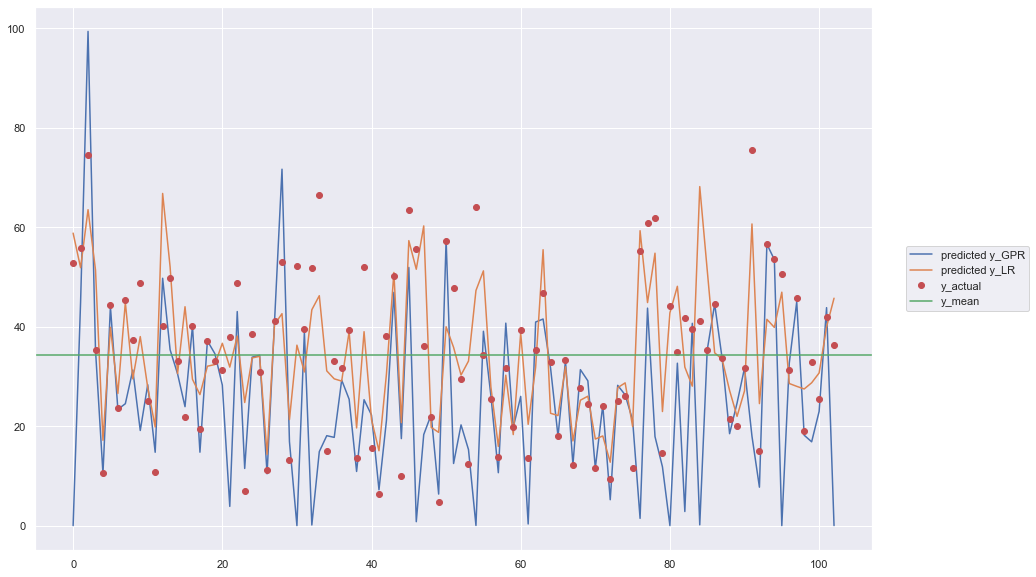

In [42]:
from matplotlib.pyplot import figure

figure(figsize=(15, 10))
plt.plot(mubest,label="predicted y_GPR")
plt.plot(pred,label="predicted y_LR")
plt.plot(y_test,'ro',label="y_actual")
plt.axhline(np.mean(y_test),color='g',label="y_mean")
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)


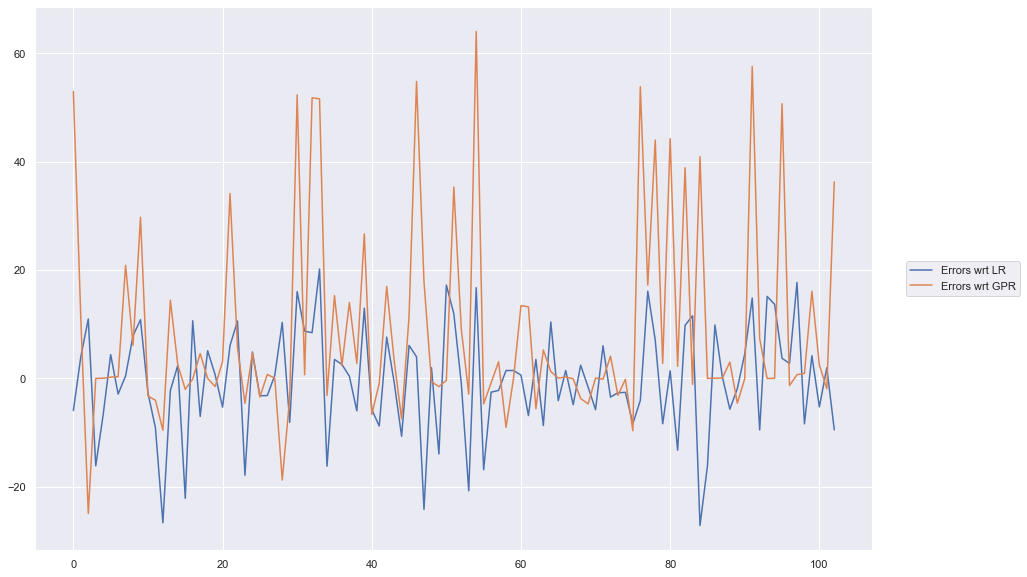

In [43]:
figure(figsize=(15, 10))
plt.plot(y_test-pred,label="Errors wrt LR")
plt.plot(y_test-mubest,label="Errors wrt GPR")
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)

In [44]:
#Comparison with Mean

from sklearn.metrics import mean_squared_error

print("MSE with GPR: {}".format(mean_squared_error(y_test,mubest)))
print("MSE with Linear Regression: {}".format(mean_squared_error(y_test,pred)))      


MSE with GPR: 426.18745163682297
MSE with Linear Regression: 101.14962490592139


References:
<li> http://www.tsc.uc3m.es/~fernando/l1.pdf
<li> https://github.com/TimoFlesch/GaussianProcess/blob/master/gaussian_process.ipynb

In [45]:
print("{0:.2}".format(1.0/3))

0.33
